In [1]:
from scene import Scene
import taichi as ti
from taichi.math import *
import taichi.math as tm
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy import ndimage
import trimesh
import open3d as o3d

%load_ext autoreload
%autoreload 2

matplotlib.use('Qt5Agg')
%matplotlib widget

[Taichi] version 1.7.1, llvm 15.0.1, commit 0f143b2f, win, python 3.11.9
Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
NUM_X, NUM_Y, NUM_Z = 100, 100, 100

def load_and_voxelize_mesh(file_path: str, voxel_size=0.005, num_x=NUM_X, num_y=NUM_Y, num_z=NUM_Z) -> np.ndarray:
    target_mesh = trimesh.load(file_path)
    assert isinstance(target_mesh, trimesh.Trimesh), "Loaded object should be a Trimesh"
    vertices = target_mesh.vertices
    faces = target_mesh.faces

    mesh = o3d.geometry.TriangleMesh()
    mesh.vertices = o3d.utility.Vector3dVector(vertices)
    mesh.triangles = o3d.utility.Vector3iVector(faces)
    mesh.compute_vertex_normals()

    voxel_grid = o3d.geometry.VoxelGrid.create_from_triangle_mesh(mesh, voxel_size)

    filled_voxels = np.zeros((num_x, num_y, num_z), dtype=np.uint8)
    for voxel in voxel_grid.get_voxels():
        voxel_coord = voxel.grid_index
        filled_voxels[voxel_coord[0], voxel_coord[1], voxel_coord[2]] = True
    for y in range(filled_voxels.shape[1]):
        slice_y = filled_voxels[:, y, :]
        filled_slice = ndimage.binary_fill_holes(slice_y)
        filled_voxels[:, y, :] = filled_slice
    print("Voxel shape:", filled_voxels.shape)  
    print("Number of filled voxels:", np.sum(filled_voxels))
    return filled_voxels


file_path = './assets/bun_zipper_res4.ply'
voxel_size = 0.005
bunny_voxels = load_and_voxelize_mesh(file_path)

Voxel shape: (100, 100, 100)
Number of filled voxels: 7449


In [3]:
@ti.func
def add_ball(r: ti.i32, pad: ti.i32, origin: tm.vec3, color: tm.vec3, mat: ti.i8):
    for i, j, k in ti.ndrange((-r-pad, r+pad), (-r-pad, r+pad), (-r-pad, r+pad)):
        xyz = ivec3(i, j, k)
        if xyz.dot(xyz) < r**2: 
            scene.set_voxel(vec3(i, j, k) + origin, mat, color, ior=1.5)

@ti.func 
def add_bunny(origin: tm.vec3, color: tm.vec3, mat: ti.i8):
    for i, j, k in ti.ndrange(NUM_X, NUM_Y, NUM_Z):
        if bunny_field[i, j, k] == 1:
            scene.set_voxel(vec3(i, j, k) + origin, mat, color, ior=1.5)

@ti.func
def origin_y(largest: int, r: int):
    return -(largest-r)-1

# Material LAMBERTIAN = 1
# Material LIGHT = 2
@ti.kernel
def initialize_voxels():
    add_ball(largest_r, 1, vec3(-18, origin_y(largest_r, largest_r), 0), RED, 1)
    add_ball(medium_r, 1, vec3(2, origin_y(largest_r, medium_r), 30), BLUE, 1)
    # add_ball(small_r, 1, vec3(17, origin_y(largest_r, small_r), -7), WHITE, 1)
    add_bunny(vec3(3, -18, -6), WHITE, 1)
    
def floor_h(largest: int):
    return -1 / 64 * (largest + 1)  #  +1 to make balls float a bit above the floor

largest_r = 18
medium_r = 12
small_r = 6
floor_height = floor_h(largest_r)
BLACK, WHITE, YELLOW, PINK = vec3(0, 0, 0), vec3(1, 1, 1), vec3(1,1,0), vec3(1,0.5,0.8)
RED, BLUE, PURPLE = vec3(0.9, 0, 0.1), vec3(0, 0.5, 1), vec3(0.2, 0.2, 0.6)

scene = Scene(exposure=1)

bunny_field = ti.field(dtype=ti.u8, shape=(NUM_X, NUM_Y, NUM_Z))
bunny_field.from_numpy(bunny_voxels)

scene.set_directional_light((0, 1, 0), 0.2, (1, 1, 1))
scene.set_background_color((1, 1, 1))
scene.set_floor(height=floor_height, color=(1, 1, 1))
initialize_voxels()
scene.finish()

[Taichi] Starting on arch=cuda

Camera:
* Drag with your left mouse button to rotate
* Press W/A/S/D/Q/E to move

[0. 0. 2.] [0. 0. 0.]


In [4]:
initial_wavefront_pos = np.array([(x, NUM_Y-1, z) for x in range(NUM_X) for z in range(NUM_Z)], dtype=np.float32)
initial_wavefront_dir = np.array([(0, -1, 0) for _ in range(NUM_X * NUM_Z)], dtype=np.float32)

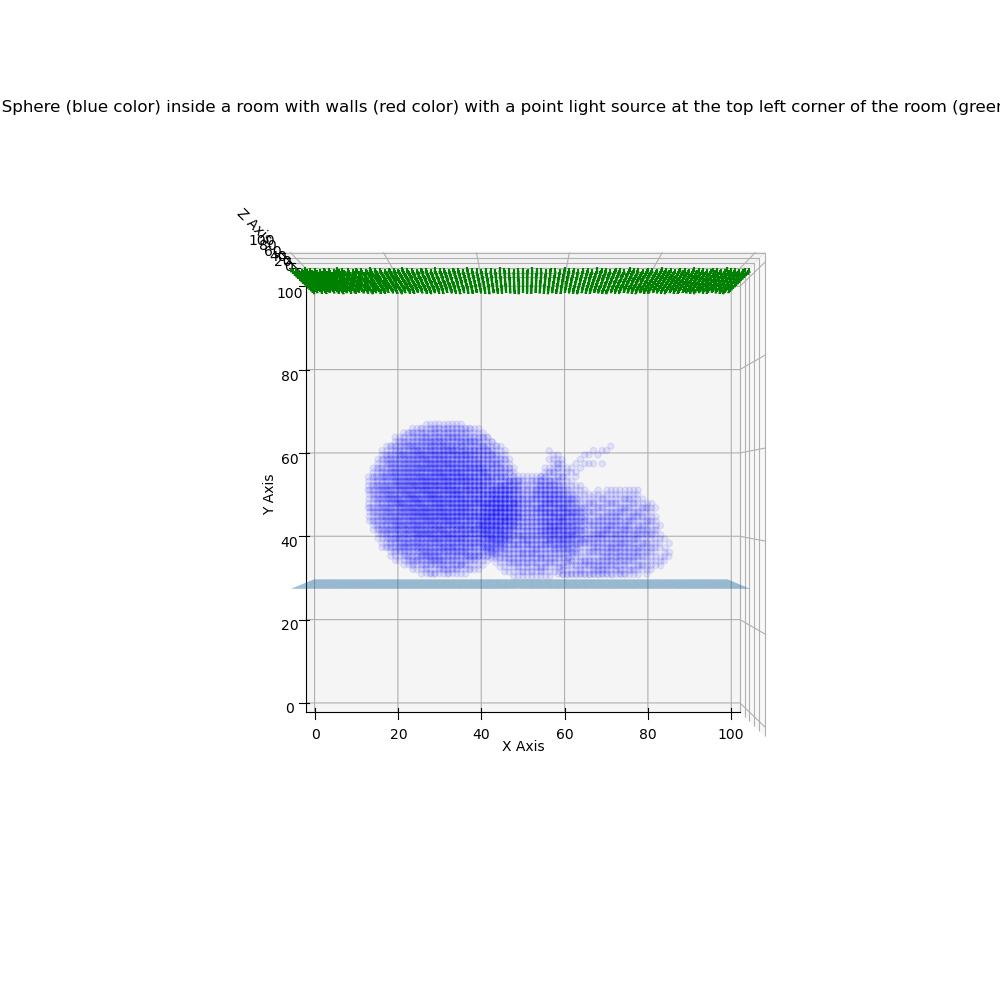

In [5]:
testor = scene.get_ior_grid()

def show_ior_field(ior_field: np.ndarray, initial_wavefront_positions: np.ndarray, initial_wavefront_directions: np.ndarray):    
    # clear previous plot
    plt.close("all")

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    ax.set_box_aspect([1,1,1])
    ax.set_xlim(0, NUM_X)
    ax.set_ylim(0, NUM_Y)
    ax.set_zlim(0, NUM_Z)
    initial_pos_np = initial_wavefront_positions    #.cpu().numpy()
    initial_dir_np = initial_wavefront_directions   #.cpu().numpy()

    # Initial wavefront positions
    subsample_indices = np.arange(0, len(initial_pos_np), 7)
    ax.quiver(initial_pos_np[subsample_indices, 0], initial_pos_np[subsample_indices, 1], initial_pos_np[subsample_indices, 2],
                initial_dir_np[subsample_indices, 0], initial_dir_np[subsample_indices, 1], initial_dir_np[subsample_indices, 2],
                color='green', length=1)
    

    # Regular sampling for the sphere
    x_points_sphere, y_points_sphere, z_points_sphere = np.where(ior_field == 1.5)
    subsample_step_sphere = max(1, len(x_points_sphere) // 4000)  # Adjust the number to control the number of points
    subsample_indices_sphere = np.arange(0, len(x_points_sphere), subsample_step_sphere)
    ax.scatter(x_points_sphere[subsample_indices_sphere], y_points_sphere[subsample_indices_sphere], z_points_sphere[subsample_indices_sphere], color='blue', alpha=0.08)
    ax.set_title("Glass Sphere (blue color) inside a room with walls (red color) with a point light source at the top left corner of the room (green arrows)")
    ax.set_xlabel('X Axis')
    ax.set_ylabel('Y Axis')
    ax.set_zlabel('Z Axis')
    ax.view_init(elev=90, azim=-90)

    xx, zz = np.meshgrid(np.arange(NUM_X), np.arange(NUM_Z))
    yy = np.ones_like(xx) * (-floor_height) * NUM_Y
    ax.plot_surface(xx, yy, zz, alpha=0.5)
    plt.show()

show_ior_field(testor.to_numpy(), initial_wavefront_pos, initial_wavefront_dir)

In [6]:
x = ti.field(float, shape=(3, 3))
a = np.arange(9).reshape(3, 3).astype(np.int32)
x.from_numpy(a)
print(x)
type(x)
arr = x.to_numpy()
print(arr)
type(arr)
field = ti.Vector.field(3, int, shape=(256, 512))
field.shape  # (256, 512)
field.n      # 3

array = field.to_numpy()
array.shape  # (256, 512, 3)
print(type(array))

field.from_numpy(array)  # the input array must in the shape (256, 512, 3)
print(type(field))

[[0. 1. 2.]
 [3. 4. 5.]
 [6. 7. 8.]]
[[0. 1. 2.]
 [3. 4. 5.]
 [6. 7. 8.]]
<class 'numpy.ndarray'>
<class 'taichi.lang.matrix.MatrixField'>


## Render